# Embedd data in control cells UMAP representation

In [2]:
import numpy as np
import anndata as ad
import pandas as pd
from matplotlib import rcParams
import scanpy as sc

import umap.umap_ as umap
import umap.plot

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import os
import config as general_paths

import warnings
warnings.filterwarnings("ignore")

/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
input_path = output_path

In [4]:
NO_PCA = 20
NO_NEIGHBORS = 15
SELECTED_LOUVAIN = 'louvain_r1'

## Read data

In [5]:
control_umap_file = 'control_umap_from_kallisto.h5ad'
adata_control_path = os.path.join(input_path,control_umap_file)

stim_adata_file = 'stim_from_kallisto.h5ad'
adata_stim_path = os.path.join(input_path,stim_adata_file)

In [6]:
adata_stim = ad.read_h5ad(adata_stim_path)
adata_control = ad.read_h5ad(adata_control_path)

In [7]:
adata_control

AnnData object with n_obs × n_vars = 606 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'sample_colors', 'stimulus_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
adata_stim

AnnData object with n_obs × n_vars = 1520 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

## Create and save new umap transformation for control data

In [9]:
# get control count matrix
control_data = adata_control.X

In [10]:
# these are my cluster labels
my_labels = adata_control.obs[SELECTED_LOUVAIN]
# for the scatter plot colormap we need labels as intigers or colors
clusters_control = [int(el) for el in my_labels.values]
NO_clusters = len(np.unique(clusters_control))

In [11]:
# Do PCA first
# 50 PCA was default in scanpy
pca_control = PCA(n_components=50, svd_solver='arpack')
pca_control_representation = pca_control.fit_transform(control_data)

Text(0.5, 1.0, 'variance ratio')

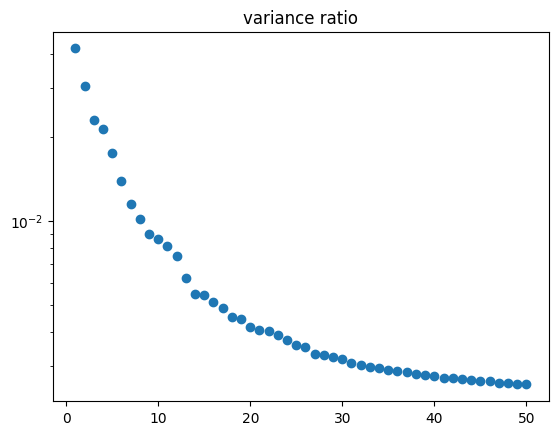

In [12]:
# pca.explained_variance_ratio_
plt.scatter([i+1 for i in range(50)],pca_control.explained_variance_ratio_)
plt.yscale('log')
plt.title("variance ratio")

In [13]:
# keep only as many as in scanpy (NO_PCA)
pca_control_representation = pca_control_representation[:,:NO_PCA]
pca_control_representation.shape

(606, 20)

In [14]:
# construct a UMAP object
umap_control = umap.UMAP(n_components= 2,
                    n_neighbors=NO_NEIGHBORS,
                    min_dist = 0.5,
                    # spread= 1.0, 
                    # init= 'spectral', 
                    # negative_sample_rate=5,
                    random_state=0).fit(pca_control_representation)

# save for the future
umap_control_only = umap_control.embedding_

umap_control.embedding_.shape

(606, 2)

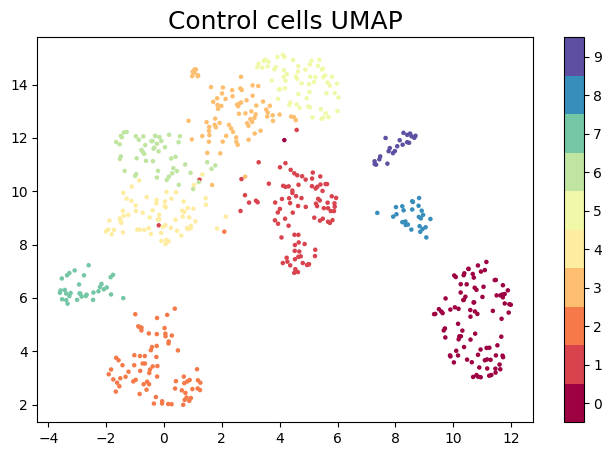

In [15]:
rcParams['figure.figsize']=(8,5)
plt.scatter(umap_control.embedding_[:, 0], umap_control.embedding_[:, 1], s= 5, c=clusters_control, cmap='Spectral')
plt.title('Control cells UMAP', fontsize=18)
plt.colorbar(boundaries=np.arange(NO_clusters+1)-0.5).set_ticks(np.arange(NO_clusters))

In [16]:
# We can now train some new models (again an SVC and a KNN classifier) on the embedded training data. 
# This looks exactly as before but now we pass it the embedded data
svc = SVC().fit(umap_control.embedding_, my_labels)
knn = KNeighborsClassifier().fit(umap_control.embedding_, my_labels)

## Perform same transformation but for stim data

In [17]:
# get stim data
stim_data = adata_stim.X

In [18]:
# Do PCA first
pca_stim_representation = pca_control.fit_transform(stim_data)

In [19]:
# keep only as many as in scanpy (NO_PCA)
pca_stim_representation = pca_stim_representation[:,:NO_PCA]
pca_stim_representation.shape

(1520, 20)

In [20]:
# Now we want to work with the test data which none of the models (UMAP or the classifiers) have seen
stim_embedding = umap_control.transform(pca_stim_representation)

Text(0.5, 1.0, 'Embedding of the stim set by UMAP')

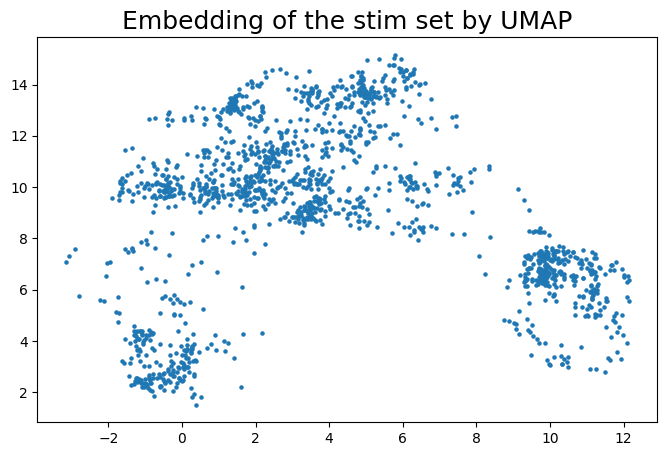

In [21]:
plt.scatter(stim_embedding[:, 0], stim_embedding[:, 1], s= 5)
plt.title('Embedding of the stim set by UMAP', fontsize=18)

Text(0, 0.5, 'UMAP2')

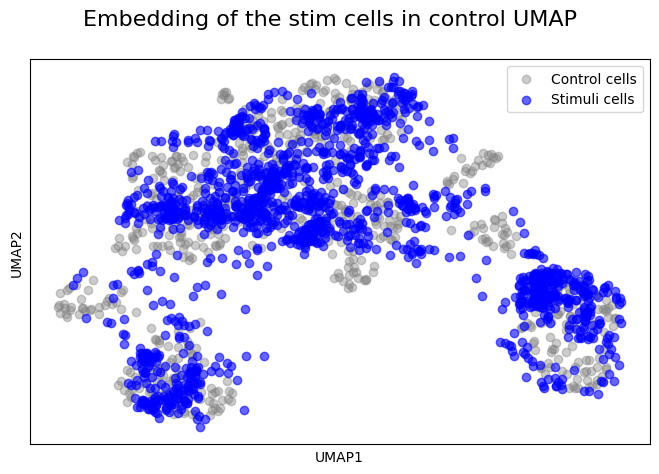

In [22]:
# show stimuli data on a control UMAP plot
figure, axes = plt.subplots()
axes.scatter(umap_control_only[:, 0], umap_control_only[:, 1],c='gray',alpha=0.4,label ="Control cells")
axes.scatter(stim_embedding[:, 0],stim_embedding[:, 1],c = 'blue',alpha=0.6, label ="Stimuli cells")
# for i in range(0,len(labels)):
#     if i in stimuli2show:
#         stim_index = np.where(stim == i)[0]
        
#         axes.scatter(adata.obsm['X_umap'][stim_index,0],adata.obsm['X_umap'][stim_index,1],label = labels[i],alpha=0.6)
# axes.grid(False)
axes.legend()
# figure.set_size_inches([9,6])
figure.suptitle("Embedding of the stim cells in control UMAP", fontsize=16)
# Hide X and Y axes tick marks
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('UMAP1')
axes.set_ylabel('UMAP2')

## Add additional information to all of that data

In [23]:
adata_stim

AnnData object with n_obs × n_vars = 1520 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

In [24]:
stim_embedding.shape

(1520, 2)

In [25]:
stimuli_ints = adata_stim.obs['stimulus'].values

In [26]:
stimuli_names = adata_stim.obs['stimulus_name'].values

In [32]:
labels=['Control','Pinch','New_stroke','Ballon','AG','AD','Heating','Mock','Old_stroke','Anal_pinch','Mock_w_poop','Vaginal_distension','Tomato','Poop', 
        'Bladder','CRD','AD+CFA','AGB+CFA','Heating+CFA','Tail Brush','TRPM8 td tomato',
        'AD + Pulse', 'AGB+CFA 1 W','AD+CFA 1W','HP','Penis','Clitoris Vibration','Max Cells',
        'Tracing Ano Genital Skin injection','Crazy Mock','Tracing Anal injection', 'Tracing Vagina']

In [46]:
# Interesting stimuli
stimuli_agb = [4,17,22]
stimuli_ad = [5,16,23]
stimuli2show = [5,16,23]
colors2show = ['blue', 'orange','green']

In [47]:
# create slices of data for stimulus to show
stim2show_data = []
for stim in stimuli2show:
    # find rows where it was
    rows = np.where(stimuli_ints == stim)[0]
    print(f"stim: {stim}, no cells: {len(rows)}")
    # select those rows
    stim2show_data.append(stim_embedding[rows])

stim: 5, no cells: 74
stim: 16, no cells: 78
stim: 23, no cells: 42


Text(0, 0.5, 'UMAP2')

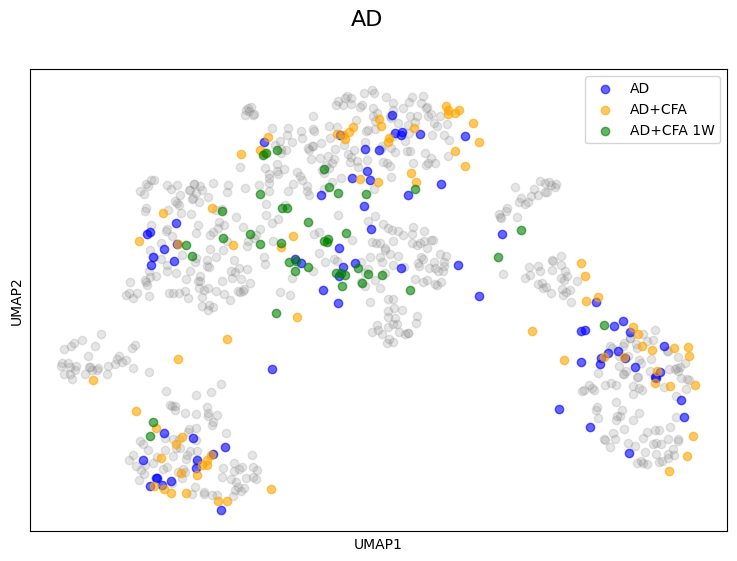

In [48]:
# show each stimulus on a single plot
figure, axes = plt.subplots()
axes.scatter(umap_control_only[:,0],umap_control_only[:,1],c='gray',alpha=0.2)
for i,stim in enumerate(stim2show_data): # for each stim
    cells_stim_name = int(stimuli2show[i]) # check what was the stim
    cells_stim_name = labels[cells_stim_name]
    current_color = colors2show[i]
    axes.scatter(stim[:,0],stim[:,1],c=current_color,label = cells_stim_name,alpha=0.6)
axes.grid(False)
axes.legend()
figure.set_size_inches([9,6])
figure.suptitle("AD", fontsize=16)
# Hide X and Y axes tick marks
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('UMAP1')
axes.set_ylabel('UMAP2')